In [38]:
import asyncio
import websockets
import json
import pandas as pd
import datetime as dt
import nest_asyncio
from concurrent.futures import ThreadPoolExecutor
nest_asyncio.apply()
from scipy import stats

import datetime
from pandas.io.json import json_normalize
import numpy as np
from scipy import interpolate
import statsmodels.api as sm
from scipy.stats import norm
from scipy.stats import skewnorm

from market_data import HistData
from market_data import Options

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Strategy Outline
1. Short (lower strike) puts and (higher strike) calls
2. Strategy assumes vol will stay muted and we harvest theta yield over time
3. Find risk-neutral implied probabiltiies of option expiring in the money for the puts and calls
4. Short calls where the probability of the option expiring with price > chosen strike is less than 10% -15%
5. Short puts where the probability of the option expiring with price < chosen strike is less than 10%-15%
6. Stop-loss when floating loss on spread is 2 times more than premium to be earned at expiry
6. In essence, probability of stopping out per trade will be 20%-30% at initiation since could be 60% at the highest (at which point we will stop out)

In [39]:
hdata = HistData('ETH')

## Options

## Get all active Eth options

### Get actively traded option chains

In [41]:
adjustment = 15
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call',date_adjustment=adjustment)
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put',date_adjustment =adjustment)
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

876 active options.
1710898187867
Expiration Date:  2024-03-22 16:00:00
878 active options.
1710898207560
Expiration Date:  2024-03-22 16:00:00


### Get Implied Probabilities
1. First method is to use the IV's themselves as the vol to calculate the implied probabilities
2. Second method is to use the atm strike's IV to calcualte the implied probabilities (Assumes a true normal distribution)

## Method 1

In [42]:
mu = 0.3
t = (option_chain_call['expiration_date'].iloc[0]-pd.datetime.today()).days/360
curr_price = curr_price * np.exp(mu*t)
curr_price

3668.5950128154454

In [43]:
option_chain_call_adj=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put_adj=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put_adj,option_chain_call_adj])

0.44947302848297


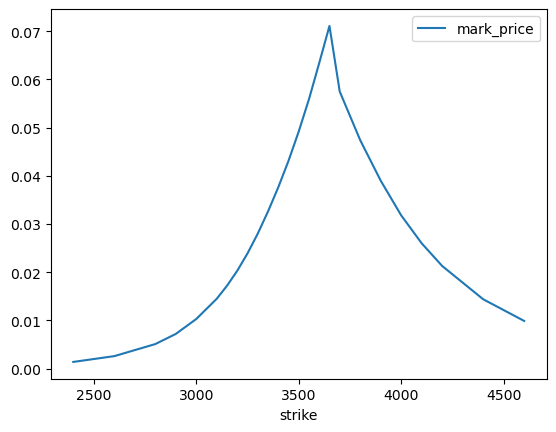

In [44]:
option_chain_full[['strike','mark_price']].set_index('strike').plot()
skewness = stats.skew(option_chain_full[['strike','mark_price']].set_index('strike'))[0]
print(skewness)

In [45]:
option_chain_full[['strike','mark_price']]

,strike,mark_price
0,2400.0,0.0014
0,2600.0,0.0026
0,2800.0,0.0051
0,2900.0,0.0072
0,3000.0,0.0103
0,3100.0,0.0145
0,3150.0,0.0172
0,3200.0,0.0203
0,3250.0,0.0239
0,3300.0,0.0280


<Axes: title={'center': 'Spread Steepness'}, xlabel='strike'>

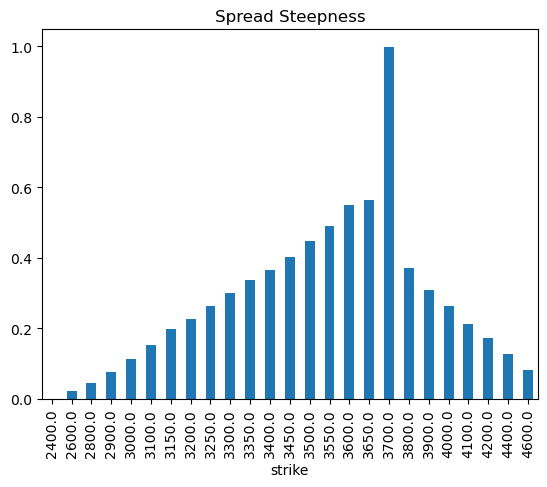

In [46]:
px_steepness=abs(option_chain_full['mark_price'].diff()*curr_price/option_chain_full['strike'].diff())
px_steepness.columns = ['spread_steepness']
px_steepness.index = option_chain_full['strike']
px_steepness.plot(kind='bar',title = 'Spread Steepness')
#We can use the put/call spread steepness to identify which legs command the highest premium to short

In [47]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_call['scaled_iv']/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*option_chain_put['scaled_iv']/100)


option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])
option_chain_full['implied_probability'] = option_chain_full['implied_probability']*(0.5/option_chain_full['implied_probability'].max())

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

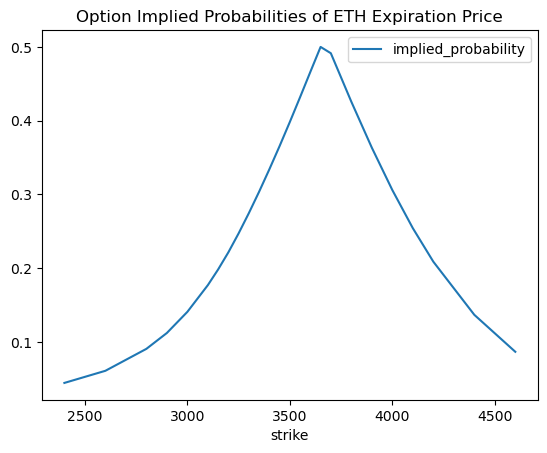

In [48]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [49]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,2400.0,0.044505
0,2600.0,0.060949
0,2800.0,0.090682
0,2900.0,0.112205
0,3000.0,0.140861
0,3100.0,0.177098
0,3150.0,0.198298
0,3200.0,0.221532
0,3250.0,0.247224
0,3300.0,0.274698


## Method 2

In [17]:
option_chain_call= opt.get_option_chain(pd.datetime.today(),option_type='call')
option_chain_put= opt.get_option_chain(pd.datetime.today(),option_type='put')
option_chain_call['scaled_iv'] = option_chain_call['mark_iv']*np.sqrt(option_chain_call['dte']/360)
option_chain_put['scaled_iv'] = option_chain_put['mark_iv']*np.sqrt(option_chain_put['dte']/360)

864 active options.
1711205408915
Expiration Date:  2024-03-29 16:00:00
864 active options.
1711205434830
Expiration Date:  2024-03-29 16:00:00


In [18]:
call_iv = option_chain_call[option_chain_call['strike']==curr_price- curr_price%100]['scaled_iv'][0]
put_iv = option_chain_put[option_chain_put['strike']==curr_price- curr_price%100]['scaled_iv'][0]

In [19]:
option_chain_call['implied_probability'] = 1-norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*call_iv/100)
option_chain_put['implied_probability'] = norm.cdf(option_chain_call['strike'].astype(float),loc = curr_price,scale=curr_price*put_iv/100)

In [20]:
option_chain_call=option_chain_call[option_chain_call['strike'].astype(float)>=curr_price]
option_chain_put=option_chain_put[option_chain_put['strike'].astype(float)<=curr_price]
option_chain_full = pd.concat([option_chain_put,option_chain_call])

<Axes: title={'center': 'Option Implied Probabilities of ETH Expiration Price'}, xlabel='strike'>

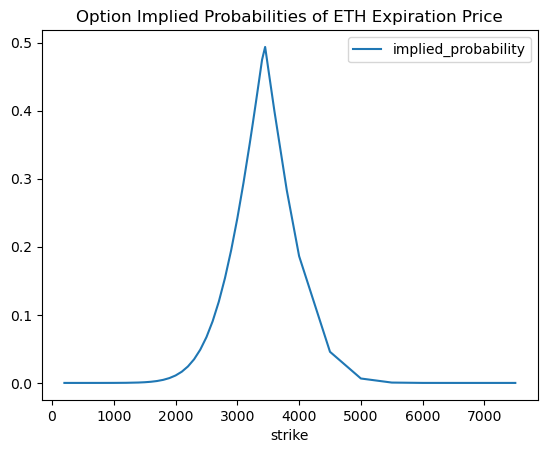

In [21]:
option_chain_full[['strike','implied_probability']].set_index('strike').plot(title='Option Implied Probabilities of ETH Expiration Price')

In [22]:
option_chain_full[['strike','implied_probability']]

,strike,implied_probability
0,200.0,1.244567e-07
0,400.0,6.489314e-07
0,500.0,1.428350e-06
0,600.0,3.068049e-06
0,800.0,1.315790e-05
0,1000.0,5.121290e-05
0,1200.0,1.810035e-04
0,1400.0,5.813006e-04
0,1500.0,1.005233e-03
0,1600.0,1.697737e-03


## Vol Skew

<Axes: xlabel='strike'>

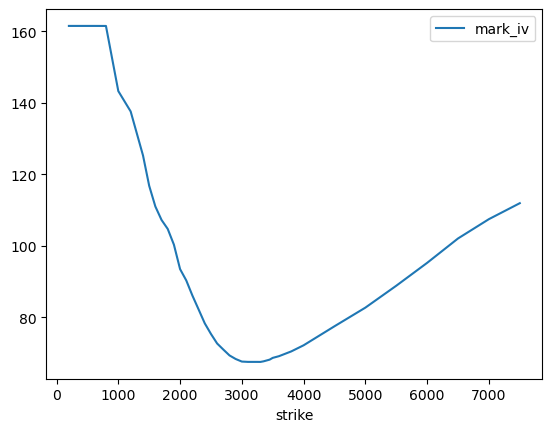

In [23]:
option_chain_full[['strike','mark_iv']].set_index('strike').plot()

## IV Adjusted Premium Calc

In [24]:
option_chain_full['adjusted_iv']=(option_chain_full['mark_iv'])**3
option_chain_full['iv_adjusted_mark_price']=option_chain_full['adjusted_iv']*option_chain_full['mark_price']

<Axes: xlabel='strike'>

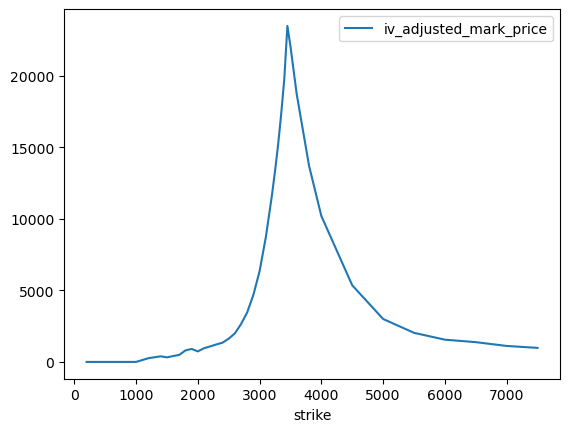

In [25]:
option_chain_full[['strike','iv_adjusted_mark_price']].set_index('strike').plot()

In [26]:
iv_gradient = pd.DataFrame(abs(option_chain_full['mark_iv'].diff()))
iv_gradient.index = option_chain_full['strike']
iv_gradient = iv_gradient[(iv_gradient.index>curr_price - 1000) & (iv_gradient.index<curr_price +1000)]

<Axes: xlabel='strike'>

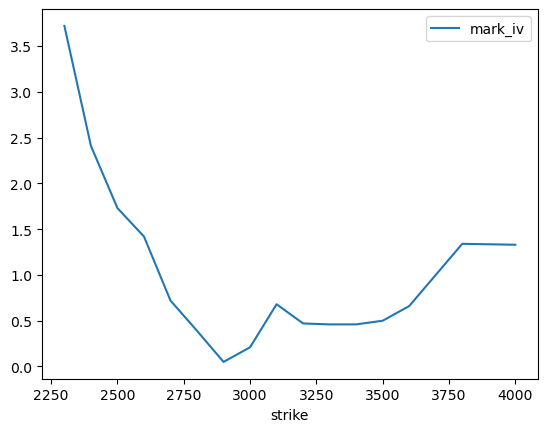

In [213]:
iv_gradient.plot()

# Check for Spot

In [546]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH',kind = 'spot')['result']

Authentication success


KeyError: 'result'

In [552]:
trade_log.columns

Index(['profit_as_cashflow', 'price_currency', 'side', 'user_role', 'trade_id',
       'interest_pl', 'contracts', 'user_seq', 'equity', 'fee_balance',
       'instrument_name', 'order_id', 'username', 'mark_price', 'user_id',
       'amount', 'index_price', 'cashflow', 'commission', 'price', 'change',
       'currency', 'balance', 'type', 'timestamp', 'position', 'info', 'id',
       'datetime', 'Date', 'direction', 'trade_type'],
      dtype='object')

In [561]:
set(trade_log['instrument_name'])

{'ETH-29MAR24-2100-P',
 'ETH-29MAR24-2300-P',
 'ETH-29MAR24-2500-P',
 'ETH-29MAR24-3300-C',
 'ETH-29MAR24-3400-C',
 'ETH-29MAR24-3500-C',
 'ETH-29MAR24-3600-C',
 'ETH-8MAR24-2200-P',
 'ETH-8MAR24-2500-P',
 'ETH-8MAR24-3300-C',
 'ETH-8MAR24-3400-C',
 'ETH-8MAR24-3600-C',
 'ETH-8MAR24-3800-C',
 'ETH_USDC',
 None}

In [560]:
-0.4+.3192+.1807+.0925

0.19239999999999996

In [577]:
usdc = ws.get_trade_log('ETH',start_dt,end_dt)

In [584]:
usdc[usdc['instrument_name']=='ETH_USDC'][['Date','amount','direction']]

,Date,amount,direction
8,2024-02-25,0.0925,1
29,2024-02-17,0.3192,1
30,2024-02-17,0.1808,1
31,2024-02-17,0.4075,-1


In [585]:
-.4075+.0925+0.3192+.1808

0.18500000000000003

In [545]:
ws.available_instruments(currency = 'ETH',kind = 'spot')

['ETH_BTC', 'ETH_USDC', 'ETH_USDT']

In [542]:
for i in positions:
    print(i['kind'])

option
option
option
option
option
option
option
option
option
option
option
option


In [592]:
hdata.get_hist_data(start_dt,end_dt,'ETH-PERPETUAL','1D')[['close']].to_csv('eth_index.csv')

In [293]:
start = int(pd.to_datetime('20221231').timestamp()*1000)
end = int(pd.datetime.today().timestamp()*1000)
timeframe = '1D'

# Update PnL Tracker

In [525]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\floating_rets.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
prev_rets = rets.sum()
print(prev_rets)



c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} Floating PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['total_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = prev_rets+ret
print('''


''')



### Get Floating PnL
shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
portfolio_greeks = pd.DataFrame(np.array([delta*10,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta10','vega','theta','gamma1000'])

with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()





rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
rets.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(rets.index)]
rets = rets[~rets.index.duplicated(keep='last')]

### Get Realized PnL
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)
realized_pnl = ws.get_agg_rel_pnl(trade_log)
realized_pnl = realized_pnl.sort_index()
rel_pnl_path = os.path.join(os.getcwd(),'performance_analytics\\realized_rets.csv') 
realized_pnl.to_csv(rel_pnl_path)

#Combine Realized and Floating PnL

rets = pd.concat([rets,realized_pnl[['PnL']].groupby(realized_pnl.index).sum()],axis=1).fillna(0).sum(axis=1)
rets = pd.DataFrame(rets.cumsum(),columns = ['Cumulative Returns (ETH)'])
pic= rets.plot(title = 'Cumulative Returns (ETH)').get_figure()
pic.savefig('CumulativePerformance.png')

# Get Greeks
greeks = pd.read_csv(r'performance_analytics\\portfolio_greeks.csv',index_col = 0)
greeks= greeks[~greeks.index.duplicated(keep='last')]
pic = greeks.plot(title = 'Greeks Dollar Exposure').get_figure()
pic.savefig('GreeksExposure.png')


Authentication success
PnL   -0.224917
dtype: float64
Position buy ETH-29MAR24-2100-P Floating PnL:-46.712433 Posn: buy 4.0
Position sell ETH-29MAR24-2300-P Floating PnL:97.204209 Posn: sell -4.0
Position sell ETH-29MAR24-2500-P Floating PnL:41.192007 Posn: sell -1.0
Position sell ETH-29MAR24-3300-C Floating PnL:-1004.950216 Posn: sell -4.0
Position sell ETH-29MAR24-3400-C Floating PnL:-185.472144 Posn: sell -1.0
Position buy ETH-29MAR24-3500-C Floating PnL:725.042773 Posn: buy 4.0
Position buy ETH-29MAR24-3600-C Floating PnL:129.873632 Posn: buy 1.0
Position buy ETH-8MAR24-2200-P Floating PnL:-13.096953 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P Floating PnL:48.959401 Posn: sell -3.0
Position sell ETH-8MAR24-3400-C Floating PnL:-98.602245 Posn: sell -1.0
Position sell ETH-8MAR24-3600-C Floating PnL:-73.049418 Posn: sell -2.0
Position buy ETH-8MAR24-3800-C Floating PnL:53.037474 Posn: buy 3.0
Total Profit:  -0.07550373700000006






In [526]:
rets

,PnL
Date,
1/2/2024,0.000000
2/2/2024,0.000000
3/2/2024,0.000000
4/2/2024,0.000000
5/2/2024,0.000000
6/2/2024,0.000000
7/2/2024,0.000000
8/2/2024,0.000000
9/2/2024,0.000000



with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()


In [524]:
rets

,PnL
2024-01-02,0.000000
2024-02-02,0.000000
2024-03-02,0.000000
2024-04-02,0.000000
2024-05-02,0.000000
2024-06-02,0.000000
2024-07-02,0.000000
2024-08-02,0.000000
2024-09-02,0.000000
2024-10-02,0.000000


In [514]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')
#dep = float(input('Enter Deposit Amount:'))
client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\floating_rets.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
prev_rets = rets.sum()
print(prev_rets)



c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} Floating PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['total_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = ret-prev_rets
print('''


''')



### Get Floating PnL
shortvolpnl = pd.DataFrame([ret[0]],index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['daily_pnl'])
portfolio_greeks = pd.DataFrame(np.array([delta*10,vega,theta,gamma]).reshape(-1,4),index = [pd.datetime.today().strftime("%Y-%m-%d")],columns = ['delta10','vega','theta','gamma1000'])

with open(perf_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(shortvolpnl)):
        temp = shortvolpnl.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()



with open(greeks_path,'a',newline = '') as csvfile:
    writer = csv.writer(csvfile)
    for i in range(len(portfolio_greeks)):
        temp = portfolio_greeks.reset_index()
        row = temp.iloc[i].values
        writer.writerow(row)
csvfile.close()





rets = pd.read_csv(r'performance_analytics\\floating_rets.csv',index_col = 0)
rets = rets[~rets.index.duplicated(keep='last')]

### Get Realized PnL
start_dt = int(pd.to_datetime('20240101').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)
trade_log = ws.get_trade_log("ETH",start_dt,end_dt)
realized_pnl = ws.get_agg_rel_pnl(trade_log)
realized_pnl = realized_pnl.sort_index()
rel_pnl_path = os.path.join(os.getcwd(),'performance_analytics\\realized_rets.csv') 
realized_pnl.to_csv(rel_pnl_path)

#Combine Realized and Floating PnL
rets.index = [dt.strftime("%Y-%m-%d") for dt in pd.to_datetime(rets.index)]
rets = pd.concat([rets,realized_pnl[['PnL']].groupby(realized_pnl.index).sum()],axis=1).fillna(0).sum(axis=1)
rets = pd.DataFrame(rets.cumsum(),columns = ['Cumulative Returns (ETH)'])
pic= rets.plot(title = 'Cumulative Returns (ETH)').get_figure()
pic.savefig('CumulativePerformance.png')

# Get Greeks
greeks = pd.read_csv(r'performance_analytics\\portfolio_greeks.csv',index_col = 0)
greeks= greeks[~greeks.index.duplicated(keep='last')]
pic = greeks.plot(title = 'Greeks Dollar Exposure').get_figure()
pic.savefig('GreeksExposure.png')


Authentication success
PnL   -0.074702
dtype: float64
Position buy ETH-29MAR24-2100-P Floating PnL:-46.655192 Posn: buy 4.0
Position sell ETH-29MAR24-2300-P Floating PnL:97.143051 Posn: sell -4.0
Position sell ETH-29MAR24-2500-P Floating PnL:41.075523 Posn: sell -1.0
Position sell ETH-29MAR24-3300-C Floating PnL:-1000.945811 Posn: sell -4.0
Position sell ETH-29MAR24-3400-C Floating PnL:-184.546975 Posn: sell -1.0
Position buy ETH-29MAR24-3500-C Floating PnL:722.157037 Posn: buy 4.0
Position buy ETH-29MAR24-3600-C Floating PnL:129.256141 Posn: buy 1.0
Position buy ETH-8MAR24-2200-P Floating PnL:-13.095857 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P Floating PnL:48.932701 Posn: sell -3.0
Position sell ETH-8MAR24-3400-C Floating PnL:-97.829103 Posn: sell -1.0
Position sell ETH-8MAR24-3600-C Floating PnL:-72.528678 Posn: sell -2.0
Position buy ETH-8MAR24-3800-C Floating PnL:52.56184 Posn: buy 3.0
Total Profit:  -0.07500220200000006






InvalidIndexError: Reindexing only valid with uniquely valued Index objects

# Offline

In [3]:
import os
import pandas as pd
os.getcwd()

'c:\\Users\\kmavy\\Documents\\mydocs\\Training Arc\\Github\\QuantMasterFund\\Crypto\\Volatility\\ShortVolatility'

In [263]:
0.1*(-160)+(0.1*-60)+0.6*80+0.1*(-160)+0.1*(-60)

4.0

In [245]:
import pandas as pd
import numpy as np
import nest_asyncio
nest_asyncio.apply()
import account_mgmt as accmgmt
import csv
import os

creds = pd.read_csv(r'C:\Users\kmavy\OneDrive\Desktop\credentials.csv')

client_id = creds['client_id'].values[0]
client_secret =creds['client_secret'].values[0]

ws = accmgmt.DeribitWS(client_id=client_id, client_secret=client_secret, live=True)
positions = ws.get_positions(currency='ETH')['result']
pnl,delta,vega,theta,gamma = 0,0,0,0,0


perf_path =os.path.join(os.getcwd(),'performance_analytics\\perf_analytics.csv') 
greeks_path = os.path.join(os.getcwd(),'performance_analytics\\portfolio_greeks.csv') 

rets = pd.read_csv(r'performance_analytics\\perf_analytics.csv',index_col = 0)
prev_rets = (1+rets).prod()-1
print(prev_rets)
dep = float(input('Enter Deposit Amount:'))
c=1
ret=0
for dets in positions:
    print(f"Position {dets['direction']} {dets['instrument_name']} PnL:{dets['floating_profit_loss_usd']} Posn: {dets['direction']} {dets['size']}")
    ret+=(dets['floating_profit_loss_usd']+dets['realized_profit_loss'])
    delta +=dets['delta']
    theta +=dets['theta']
    vega +=dets['vega']
    gamma+=dets['gamma']
    c+=1
print('Total Profit: ',ret)
ret = ret/dep
ret = ((1+ret)/(1+prev_rets))-1
print('''


''')

Authentication success
PnL   -0.141668
dtype: float64
Position buy ETH-29MAR24-2100-P PnL:-45.581751 Posn: buy 4.0
Position sell ETH-29MAR24-2300-P PnL:96.602266 Posn: sell -4.0
Position sell ETH-29MAR24-2500-P PnL:41.377901 Posn: sell -1.0
Position sell ETH-29MAR24-3300-C PnL:-941.965063 Posn: sell -4.0
Position sell ETH-29MAR24-3400-C PnL:-171.245835 Posn: sell -1.0
Position buy ETH-29MAR24-3500-C PnL:670.933411 Posn: buy 4.0
Position buy ETH-29MAR24-3600-C PnL:117.297127 Posn: buy 1.0
Position buy ETH-8MAR24-2200-P PnL:-13.072412 Posn: buy 3.0
Position sell ETH-8MAR24-2500-P PnL:49.331745 Posn: sell -3.0
Position sell ETH-8MAR24-3400-C PnL:-82.438292 Posn: sell -1.0
Position sell ETH-8MAR24-3600-C PnL:-52.121715 Posn: sell -2.0
Position buy ETH-8MAR24-3800-C PnL:37.684643 Posn: buy 3.0
Total Profit:  -293.19797500000004






# Trade Log Function

In [274]:
start_dt = int(pd.to_datetime('20240201').timestamp()*1000)
end_dt = int(pd.datetime.today().timestamp()*1000)

def get_trade_log(currency,start_dt,end_dt):
    log=ws.get_trade_hist(currency,start_dt,end_dt)
    logs = pd.DataFrame()
    ttd_instrument_hist = []
    for i in range(len(log['result']['logs'])):
        instrument = log['result']['logs'][i]['instrument_name']
        ttd_instrument_hist.append(instrument)
        #if instrument =="ETH-8MAR24-3600-C" or instrument =='ETH-8MAR':
        temp = pd.DataFrame(log['result']['logs'][i].values(),index =log['result']['logs'][i].keys())
        logs = pd.concat([logs,temp],axis=1)
    trade_log = logs.T
    trade_log.index = range(len(trade_log))
    trade_log['datetime'] = [datetime.datetime.fromtimestamp(int(str(dt)[:-3])) for dt in trade_log.timestamp]
    trade_log['Date'] = [dt.strftime("%Y-%m-%d") for dt in trade_log.datetime]
    trade_log['side']=trade_log['side'].replace('-',"N.A. N.A.")
    trade_log['direction'] = [side.split(" ")[1] for side in trade_log.side]
    trade_log['direction'] = [1 if direction =='buy' else -1 if direction =='sell' else 0 for direction in trade_log.direction]
    trade_log['trade_type'] = [side.split(" ")[0] for side in trade_log.side]
    return trade_log
trade_log = get_trade_log("ETH",start_dt,end_dt)

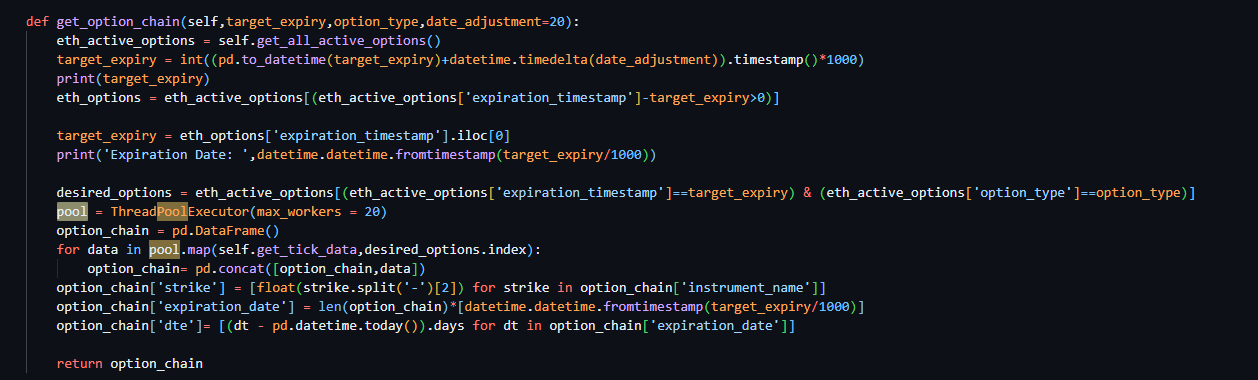
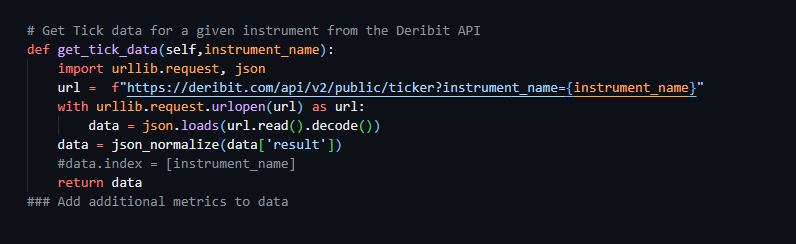

In [230]:
def get_realized_pnl(trade_log,instrument):
    def net_closing_px(exits):
        weighted_exit = sum(exits['direction']*exits['amount']*exits['price'])/sum(exits['amount'])
        return weighted_exit
    trade_log = trade_log[trade_log['instrument_name']==instrument]
    realized_position = sum((trade_log['direction']*trade_log['amount']).dropna())
    entries = trade_log[trade_log['trade_type']=='open']
    exits = trade_log[trade_log['trade_type']=='close']
    #return exits
    if exits.empty or entries.empty:
        return pd.DataFrame()
    weighted_entry = sum(entries['direction']*entries['amount']*entries['price'])/sum(entries['amount'])
    weighted_exits = exits.groupby('Date').apply(net_closing_px)
    weighted_exits = pd.DataFrame(weighted_exits,columns = ['Realized PnL'])
    realized_pnl = weighted_exits - weighted_entry 
    realized_pnl['instrument']=[instrument]*len(realized_pnl)
    #realized_pnl = (weighted_exit - weighted_entry)/abs(realized_position)
    #print(weighted_entry,weighted_exit,realized_position)
    return realized_pnl


In [273]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def get_agg_rel_pnl(trade_log):
    pool = ThreadPoolExecutor(max_workers = 20)
    RealizedPnL = pd.DataFrame()
    agg_rel_pnl_func = partial(get_realized_pnl,trade_log)
    ttd_instruments = set(trade_log.instrument_name)
    for data in pool.map(agg_rel_pnl_func,ttd_instruments):
        RealizedPnL = pd.concat([RealizedPnL,data],axis=0)
    RealizedPnL['type'] = [len(i.split("-")) for i in Realized_PnL['instrument']]
    RealizedPnL['type'] = ['option' if i==4 else 'future' if i==2 else 'spot' if i==1 else "unknown"]
    return RealizedPnL

RealizedPnL
    

,Realized PnL,instrument
Date,,
2024-02-27,-0.01700,ETH-8MAR24-3300-C
2024-02-26,0.00622,ETH-8MAR24-3600-C
2024-02-27,0.00912,ETH-8MAR24-3600-C


In [111]:
trade_log.columns

Index(['profit_as_cashflow', 'price_currency', 'side', 'user_role', 'trade_id',
       'interest_pl', 'contracts', 'user_seq', 'equity', 'fee_balance',
       'instrument_name', 'order_id', 'username', 'mark_price', 'user_id',
       'amount', 'index_price', 'cashflow', 'commission', 'price', 'change',
       'currency', 'balance', 'type', 'timestamp', 'position', 'info', 'id',
       'datetime', 'Date', 'direction'],
      dtype='object')

In [119]:
trade_log[trade_log['instrument_name']=="ETH-8MAR24-3600-C"][['instrument_name','side','price_currency','profit_as_cashflow','trade_type','commission','price','contracts','amount','direction','datetime','trade_id','Date']]

,instrument_name,side,price_currency,profit_as_cashflow,trade_type,commission,price,contracts,amount,direction,datetime,trade_id,Date
0,ETH-8MAR24-3600-C,open sell,ETH,False,open,0.0003,0.008,1.0,1.0,-1,2024-02-27 00:25:36,ETH-195089436,2024-02-27
1,ETH-8MAR24-3600-C,open sell,ETH,False,open,0.0003,0.008,1.0,1.0,-1,2024-02-27 00:25:36,ETH-195089435,2024-02-27
2,ETH-8MAR24-3600-C,close sell,ETH,False,close,0.0006,0.0075,2.0,2.0,-1,2024-02-27 00:24:45,ETH-195089153,2024-02-27
6,ETH-8MAR24-3600-C,close sell,ETH,False,close,0.0003,0.0046,1.0,1.0,-1,2024-02-26 01:14:42,ETH-194918236,2024-02-26
9,ETH-8MAR24-3600-C,open buy,ETH,False,open,0.0003,0.0027,1.0,1.0,1,2024-02-24 02:16:06,ETH-194754812,2024-02-24
14,ETH-8MAR24-3600-C,open buy,ETH,False,open,0.0006,0.0026,2.0,2.0,1,2024-02-24 00:31:31,ETH-194746322,2024-02-24
